In [37]:
# run command:$ jupyter nbconvert --to notebook --inplace --execute main.ipynb

from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.callbacks import TensorBoard
from sklearn.decomposition import PCA
import numpy as np
import os

In [2]:
# define the scaler
scaler = MinMaxScaler()

# label encoder
label_encoder = LabelEncoder()

# Load MNIST dataset
mnist = fetch_openml('mnist_784')
images = mnist['data']
labels = mnist['target']

# Normalize the data
images_normalized = scaler.fit_transform(images)

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_normalized, labels, test_size=0.1)

# Print the shape of the dataset
print("(Number of images, Shape of images):", images.shape)
print("(Number of labels):", labels.shape)

(Number of images, Shape of images): (70000, 784)
(Number of labels): (70000,)


Reconstruction Error: 0.0075269626220684


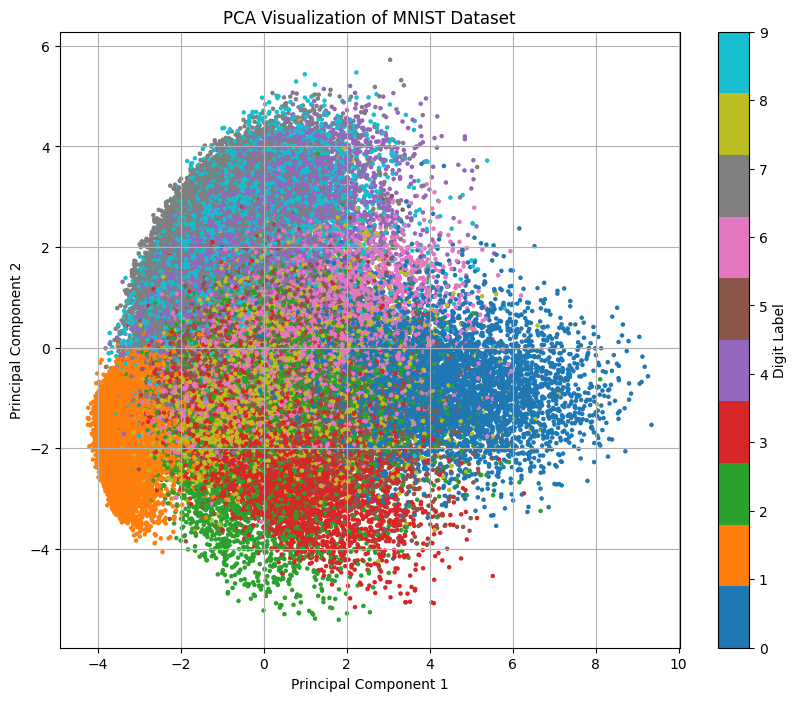

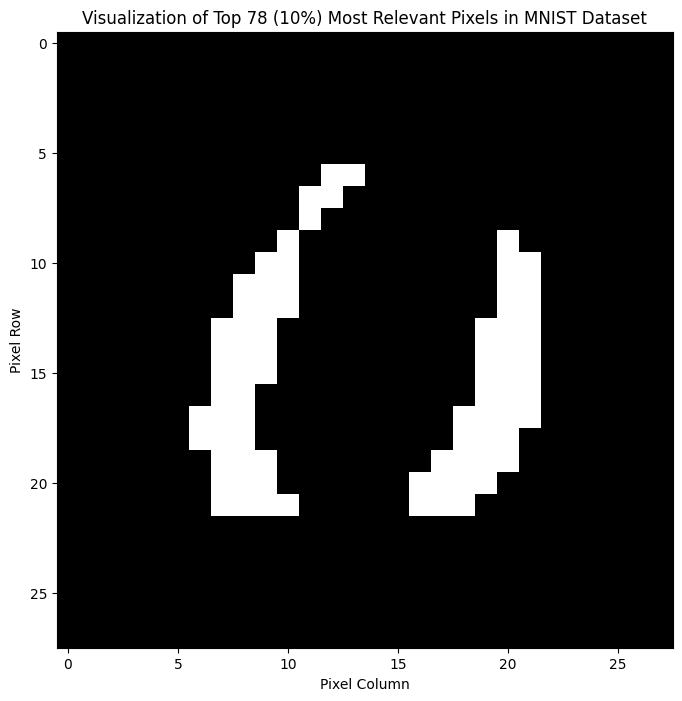

In [33]:
# Perform PCA
features = 78
pca = PCA(n_components=features)  # Reduce the dimensionality to 2 for visualization
X_train_pca = pca.fit_transform(X_train)
X_train_reconstructed = pca.inverse_transform(X_train_pca)

# Get the most relevant features (pixels) for the first principal component
most_relevant_features = np.argsort(pca.components_[0])[-features:][::-1]

# Compute the reconstruction error
reconstruction_error = np.mean(np.square(X_train - X_train_reconstructed))

# Print the reconstruction error
print("Reconstruction Error:", reconstruction_error)

plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train.astype(int), cmap='tab10', s=5)  # Use 'tab10' colormap
plt.colorbar(label='Digit Label')
plt.title('PCA Visualization of MNIST Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.grid(True)
plt.show()

# Create a 28x28 grid
grid = np.zeros((28, 28))

# Set the value of the top 10 most relevant pixels to 1
top_pixels = np.argsort(pca.components_[0])[-features:]  # Get indices of top 10 pixels
for pixel_idx in top_pixels:
    row_idx = pixel_idx // 28
    col_idx = pixel_idx % 28
    grid[row_idx, col_idx] = 1  # Highlight the pixel

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid, cmap='gray', interpolation='nearest')
plt.title('Visualization of Top 78 (10%) Most Relevant Pixels in MNIST Dataset')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.grid(False)
plt.show()


In [4]:
# Define the SVM model
svm_classifier = SVC(kernel='rbf', C=10, gamma='scale')

# train the model
svm_classifier.fit(X_train, y_train)

# Evaluate the model
accuracy = svm_classifier.score(X_test, y_test)
print("Accuracy of SVM classifier:", accuracy)


Accuracy of SVM classifier: 0.9848571428571429


In [5]:
# GBT takes a really long to run
# Define the Gradient Boosting model
clf_gbt = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.05,
    max_depth=2,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    verbose=0,
)

# train the model
clf_gbt.fit(X_train, y_train)

# Evaluate the model
accuracy = clf_gbt.score(X_test, y_test)
print("Accuracy of GBT classifier:", accuracy)

Accuracy of GBT classifier: 0.8502857142857143


In [35]:
# define the Convolutional Neural Network

tensorboard_callback = TensorBoard(log_dir="./logs")

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# Convert labels to integer format for CNN
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Reshape data for CNN input, inputs are 28x28 gray scale
X_train_reshaped = X_train.reshape(-1, 28, 28, 1)
X_test_reshaped = X_test.reshape(-1, 28, 28, 1)

# train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(X_train_reshaped, y_train_encoded, epochs=5, callbacks=[tensorboard_callback])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped,  y_test_encoded, verbose=0)
print("Accuracy of CNN classifier:", test_acc)


Epoch 1/5
1724/1969 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8919 - loss: 0.3448

KeyboardInterrupt: 

ModuleNotFoundError: No module named 'keras.wrappers'

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


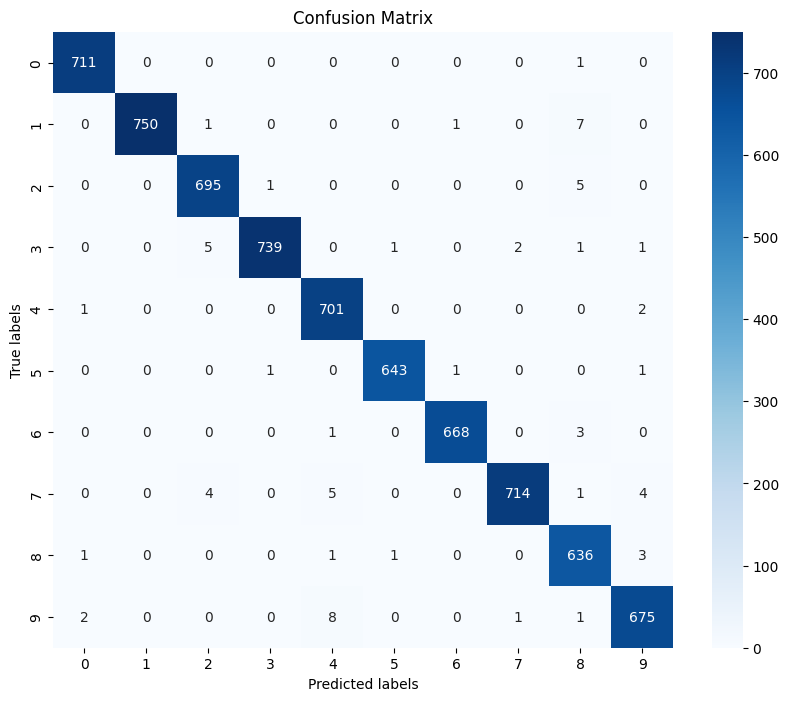

In [5]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions on test data
y_pred = np.argmax(model.predict(X_test_reshaped), axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Probability of digit 0: 0.75%
Probability of digit 1: 85.05%
Probability of digit 2: 6.65%
Probability of digit 3: 4.34%
Probability of digit 4: 0.27%
Probability of digit 5: 0.48%
Probability of digit 6: 0.99%
Probability of digit 7: 0.68%
Probability of digit 8: 0.37%
Probability of digit 9: 0.42%


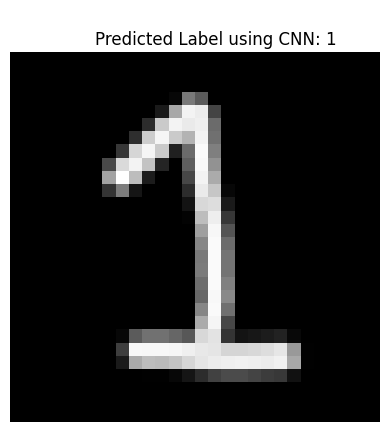

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Probability of digit 0: 0.03%
Probability of digit 1: 99.57%
Probability of digit 2: 0.05%
Probability of digit 3: 0.02%
Probability of digit 4: 0.07%
Probability of digit 5: 0.02%
Probability of digit 6: 0.10%
Probability of digit 7: 0.01%
Probability of digit 8: 0.11%
Probability of digit 9: 0.01%


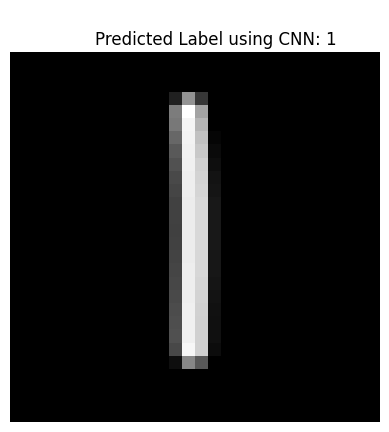

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Probability of digit 0: 2.43%
Probability of digit 1: 14.11%
Probability of digit 2: 19.71%
Probability of digit 3: 6.56%
Probability of digit 4: 0.95%
Probability of digit 5: 0.65%
Probability of digit 6: 0.71%
Probability of digit 7: 52.38%
Probability of digit 8: 1.73%
Probability of digit 9: 0.76%


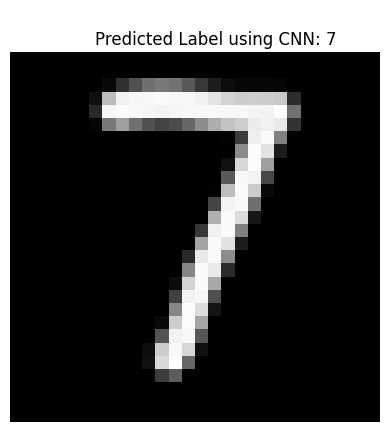

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Probability of digit 0: 0.08%
Probability of digit 1: 0.00%
Probability of digit 2: 99.86%
Probability of digit 3: 0.02%
Probability of digit 4: 0.00%
Probability of digit 5: 0.00%
Probability of digit 6: 0.01%
Probability of digit 7: 0.02%
Probability of digit 8: 0.02%
Probability of digit 9: 0.00%


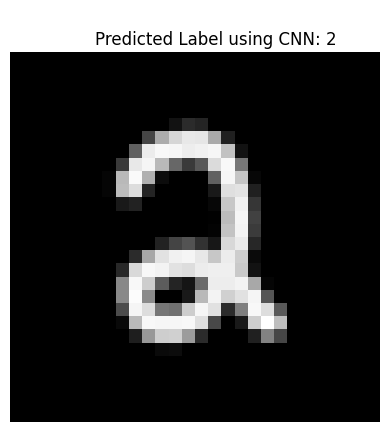

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Probability of digit 0: 0.00%
Probability of digit 1: 0.14%
Probability of digit 2: 0.02%
Probability of digit 3: 0.18%
Probability of digit 4: 0.02%
Probability of digit 5: 99.39%
Probability of digit 6: 0.16%
Probability of digit 7: 0.02%
Probability of digit 8: 0.01%
Probability of digit 9: 0.06%


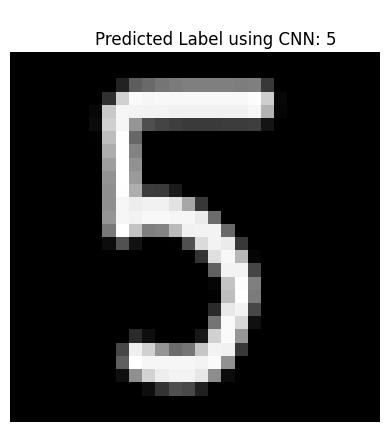

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Probability of digit 0: 0.01%
Probability of digit 1: 0.02%
Probability of digit 2: 0.05%
Probability of digit 3: 99.76%
Probability of digit 4: 0.00%
Probability of digit 5: 0.07%
Probability of digit 6: 0.00%
Probability of digit 7: 0.02%
Probability of digit 8: 0.02%
Probability of digit 9: 0.05%


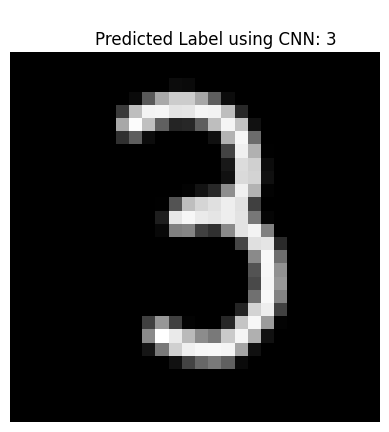

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Probability of digit 0: 0.03%
Probability of digit 1: 0.96%
Probability of digit 2: 0.88%
Probability of digit 3: 0.27%
Probability of digit 4: 50.77%
Probability of digit 5: 0.69%
Probability of digit 6: 0.01%
Probability of digit 7: 3.14%
Probability of digit 8: 2.39%
Probability of digit 9: 40.86%


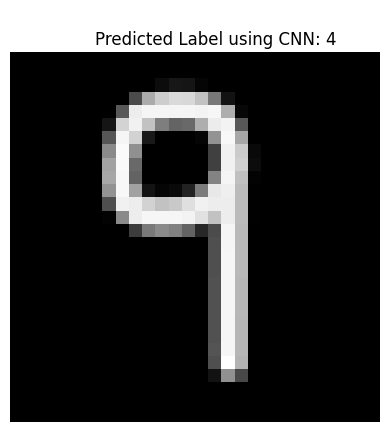

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Probability of digit 0: 0.19%
Probability of digit 1: 2.22%
Probability of digit 2: 3.59%
Probability of digit 3: 5.27%
Probability of digit 4: 1.57%
Probability of digit 5: 0.14%
Probability of digit 6: 0.16%
Probability of digit 7: 85.95%
Probability of digit 8: 0.74%
Probability of digit 9: 0.18%


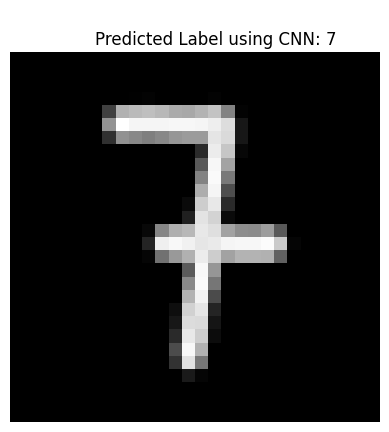

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probability of digit 0: 0.00%
Probability of digit 1: 0.00%
Probability of digit 2: 0.00%
Probability of digit 3: 0.00%
Probability of digit 4: 99.99%
Probability of digit 5: 0.00%
Probability of digit 6: 0.00%
Probability of digit 7: 0.00%
Probability of digit 8: 0.00%
Probability of digit 9: 0.00%


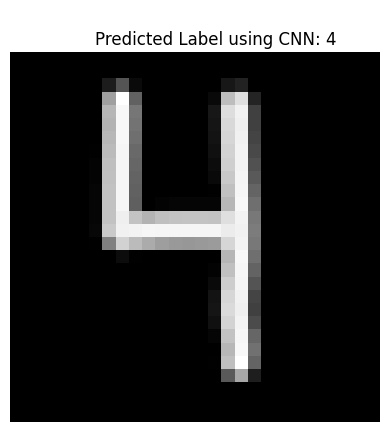

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probability of digit 0: 0.01%
Probability of digit 1: 0.14%
Probability of digit 2: 0.06%
Probability of digit 3: 0.00%
Probability of digit 4: 95.43%
Probability of digit 5: 0.06%
Probability of digit 6: 0.01%
Probability of digit 7: 0.11%
Probability of digit 8: 2.27%
Probability of digit 9: 1.91%


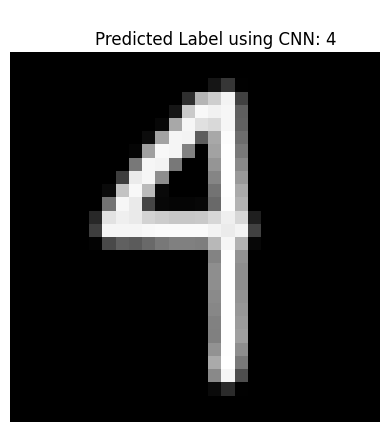

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probability of digit 0: 0.05%
Probability of digit 1: 0.05%
Probability of digit 2: 99.83%
Probability of digit 3: 0.00%
Probability of digit 4: 0.00%
Probability of digit 5: 0.00%
Probability of digit 6: 0.00%
Probability of digit 7: 0.03%
Probability of digit 8: 0.04%
Probability of digit 9: 0.00%


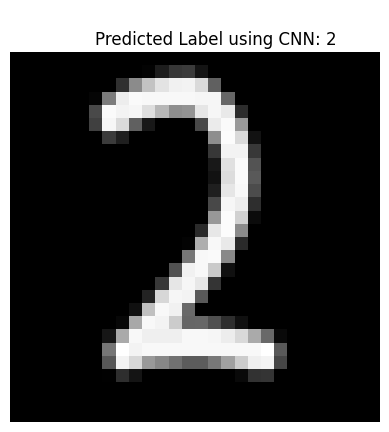

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probability of digit 0: 0.19%
Probability of digit 1: 0.10%
Probability of digit 2: 1.77%
Probability of digit 3: 5.80%
Probability of digit 4: 0.19%
Probability of digit 5: 0.56%
Probability of digit 6: 0.48%
Probability of digit 7: 0.07%
Probability of digit 8: 90.52%
Probability of digit 9: 0.32%


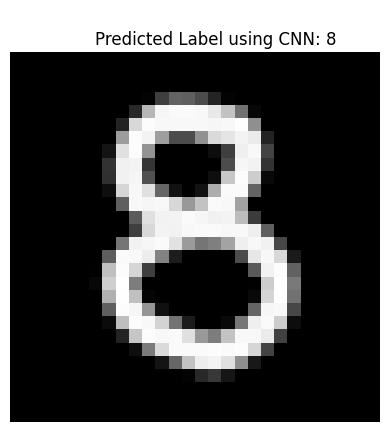

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Probability of digit 0: 0.10%
Probability of digit 1: 0.00%
Probability of digit 2: 0.01%
Probability of digit 3: 0.00%
Probability of digit 4: 0.00%
Probability of digit 5: 1.04%
Probability of digit 6: 98.82%
Probability of digit 7: 0.00%
Probability of digit 8: 0.03%
Probability of digit 9: 0.00%


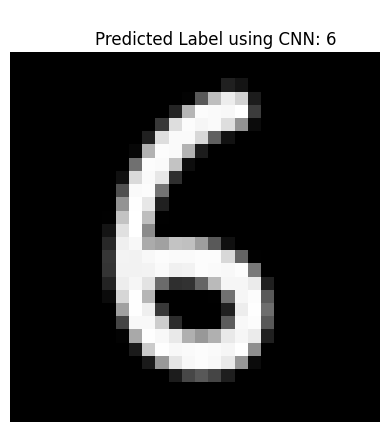

In [6]:
# convert an image I drew to test the model with

# Directory containing images
directory = "images/"

# Iterate through each image in the directory
for filename in os.listdir(directory):
    if filename.endswith(".png"):
        # Load the handwritten image as grayscale
        image = Image.open(os.path.join(directory, filename)).convert("L")

        # Resize the image to 28x28 pixels
        image = image.resize((28, 28))

        # Invert the pixel values
        image = ImageOps.invert(image)

        # Convert the image to a numpy array
        image_array = np.array(image)

        # Flatten the image array
        image_flattened = image_array.flatten()

        # Scale the pixel values to the range [0, 1]
        # this is equivalent to using the MinMaxScaler()
        image_scaled = image_flattened / 255.0

        # Predict the label using the trained models
        '''predicted_label_svm = svm_classifier.predict([image_scaled])[0]
        predicted_label_gbt = clf_gbt.predict([image_scaled])[0]'''

        # Predict with CNN
        ni = image_scaled.reshape(-1, 28, 28, 1)
        logits = model.predict([ni])[0]
        predicted_label_cnn = np.argmax(logits) # make the prediction the index with highest value
        # Display the percentages 
        probs = np.exp(logits) / np.sum(np.exp(logits)) # Apply softmax function
        percentages = probs * 100 # Convert to percentages
        for i, percentage in enumerate(percentages):
            print(f"Probability of digit {i}: {percentage:.2f}%")

        # define an image that can be shown to compare to the prediction
        image_to_show = image_scaled.reshape(28, 28)

        # Display the image along with the predicted labels
        plt.imshow(image_to_show, cmap='gray')
        plt.axis('off')
        plt.title(f'\n\
        Predicted Label using CNN: {predicted_label_cnn}')
        plt.show()
